# Evaluation script

## Load packages

In [128]:
Sys.setenv("PKG_CXXFLAGS"="-std=c++14")

# List of required packages
list_of_packages <- c("here", "dplyr", "ggplot2", "reshape2", "xtable")

# Function to load packages and handle errors
load_if_installed <- function(p) {
  tryCatch({
    library(p, character.only = TRUE)
  }, error = function(e) {
    message(sprintf("Package '%s' is not installed.", p))
  })
}

# Load all required packages
lapply(list_of_packages, load_if_installed)

[[1]]
 [1] "xtable"    "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "xtable"    "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "xtable"    "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "xtable"    "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "xtable"    "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

## Load results

In [129]:
datanames <- c("cps", "adult")
modelnames <- c("orig", "orig_dis", "cart", "rf", "bn", "xgb", "svm")
seeds <- 1235:1244

loaded_data <- list()

# Loop through all combinations of dataname and modelname
for (dataname in datanames) {
  for (modelname in modelnames) {
    for (seed in seeds) {
      # Construct the file path
      file_path <- paste0(here(), "/results/", dataname, "_", modelname, "_res_", seed, ".RData")
      
      # Check if the file exists
      if (file.exists(file_path)) {
        # Create a new environment to load the RData
        env <- new.env()
        
        # Load the file into the environment
        load(file = file_path, envir = env)
        
        # Assume the result object inside the RData file is always named "cps_res" or "adult_res"
        # Check which object is in the environment and assign it to the list under a unique name
        result_name <- ls(env)[1]  # Get the name of the loaded object (either cps_res or adult_res)
        
        # Rename "orig" to "og" when saving
        save_modelname <- ifelse(modelname == "orig", "og", modelname)
        loaded_data[[paste0(dataname, "_", save_modelname, "_", seed)]] <- env[[result_name]]
        
        cat("Loaded data for:", dataname, save_modelname, seed, "\n")
      } else {
        # Print message if the file does not exist
        cat("Data does not exist for:", dataname, modelname, seed, "\n")
      }
    }
  }
}

# Print all loaded dataframes
cat("\n--- List of loaded dataframes ---\n")
for (name in names(loaded_data)) {
  cat("Data for:", name, "\n")
  print(loaded_data[[name]])
}


Loaded data for: cps og 1235 
Loaded data for: cps og 1236 
Loaded data for: cps og 1237 
Loaded data for: cps og 1238 
Loaded data for: cps og 1239 
Loaded data for: cps og 1240 
Loaded data for: cps og 1241 
Loaded data for: cps og 1242 
Loaded data for: cps og 1243 
Loaded data for: cps og 1244 
Loaded data for: cps orig_dis 1235 
Loaded data for: cps orig_dis 1236 
Loaded data for: cps orig_dis 1237 
Loaded data for: cps orig_dis 1238 
Loaded data for: cps orig_dis 1239 
Loaded data for: cps orig_dis 1240 
Loaded data for: cps orig_dis 1241 
Loaded data for: cps orig_dis 1242 
Loaded data for: cps orig_dis 1243 
Loaded data for: cps orig_dis 1244 
Loaded data for: cps cart 1235 
Loaded data for: cps cart 1236 
Loaded data for: cps cart 1237 
Loaded data for: cps cart 1238 
Loaded data for: cps cart 1239 
Loaded data for: cps cart 1240 
Loaded data for: cps cart 1241 
Loaded data for: cps cart 1242 
Loaded data for: cps cart 1243 
Loaded data for: cps cart 1244 
Loaded data for: cps

In [130]:
print(loaded_data[["cps_og_1235"]])

[[1]]
          MAE        MSE     RMSE R_squared     MAPE
CART 26383.18 1724445436 41521.48 0.2877267 4549.470
RF   25029.53 1596826192 39953.84 0.3403154 4335.911
XGB  24845.18 1585614630 39813.89 0.3450706 4314.250
SVM  24072.22 1689887339 41105.99 0.3020326 3666.865

[[2]]
   Accuracy        F1 Sensitivity Specificity
1 0.9603934 0.9797966        0.22         0.8



## Average results over seeds

In [131]:
modelnames <- c("og", "orig_dis", "cart", "rf", "bn", "xgb", "svm")

# Function to average a list of dataframes, ensuring they are of the same size
average_dataframes <- function(df_list) {
  # Check that all dataframes have the same dimensions
  first_df <- df_list[[1]]
  same_size <- sapply(df_list, function(x) all(dim(x) == dim(first_df)))
  
  if (all(same_size)) {
    df_avg <- Reduce("+", df_list) / length(df_list)
    return(df_avg)
  } else {
    cat("Dataframes do not have the same size. Printing the dataframes:\n")
    for (i in seq_along(df_list)) {
      cat("Dataframe", i, ":\n")
      print(df_list[[i]])
      cat("\n")
    }
    stop("Not all dataframes have the same size.")
  }
}

# Initialize list to store averaged results
averaged_data <- list()

# Loop through the datanames and modelnames to average dataframes
for (dataname in datanames) {
  for (modelname in modelnames) {
    # Filter the list of loaded data for the current dataname and modelname
    data_key <- paste0(dataname, "_", modelname, "_")
    model_data <- loaded_data[grep(data_key, names(loaded_data))]
    
    # If the model data for this combination is available, average the dataframes
    if (length(model_data) > 0) {
      if (dataname == "cps") {
        # For cps data, extract the nested lists
        first_df_list <- lapply(model_data, function(x) x[[1]])  # Extract first dataframe
        second_df_list <- lapply(model_data, function(x) x[[2]])  # Extract second dataframe
        
        # Average the first and second dataframes separately over the seeds
        cat("Averaging first dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname)]] <- average_dataframes(first_df_list)
        
        cat("Averaging second dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname, "_bn_pred")]] <- average_dataframes(second_df_list)
        
      } else if (dataname == "adult") {
        # For adult data, extract the single dataframe from the nested structure
        df_list <- lapply(model_data, function(x) x[[1]])
        
        # Average the dataframe over the seeds
        cat("Averaging dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname)]] <- average_dataframes(df_list)
      }
      
      cat("Averaged data for:", dataname, modelname, "\n")
    } else {
      cat("No data to average for:", dataname, modelname, "\n")
    }
  }
}

# Print the averaged dataframes
for (name in names(averaged_data)) {
  cat("Averaged data for:", name, "\n")
  print(averaged_data[[name]])
}

Averaging first dataframe for: cps og 
Averaging second dataframe for: cps og 
Averaged data for: cps og 
Averaging first dataframe for: cps orig_dis 
Averaging second dataframe for: cps orig_dis 
Averaged data for: cps orig_dis 
Averaging first dataframe for: cps cart 
Averaging second dataframe for: cps cart 
Averaged data for: cps cart 
Averaging first dataframe for: cps rf 
Averaging second dataframe for: cps rf 
Averaged data for: cps rf 
Averaging first dataframe for: cps bn 
Averaging second dataframe for: cps bn 
Averaged data for: cps bn 
Averaging first dataframe for: cps xgb 
Averaging second dataframe for: cps xgb 
Averaged data for: cps xgb 
No data to average for: cps svm 
Averaging dataframe for: adult og 
Averaged data for: adult og 
Averaging dataframe for: adult orig_dis 
Averaged data for: adult orig_dis 
Averaging dataframe for: adult cart 
Averaged data for: adult cart 
Averaging dataframe for: adult rf 
Averaged data for: adult rf 
Averaging dataframe for: adult b

## Metric Tables

In [132]:
# Define the datasets and models
datanames <- c("cps", "adult")
modelnames <- c("og", "cart", "rf", "xgb", "svm")  # Excluding "orig_dis"
metrics_regression <- c("MAE", "MSE", "RMSE", "R_squared", "MAPE") # For cps
metrics_classification <- c("Accuracy", "F1", "Sensitivity", "Specificity") # For adult

# Initialize empty data frames for cps and adult datasets
cps_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(cps_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

adult_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(adult_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

# Fill in the cps table with regression metrics
for (model in c("CART", "RF", "XGB", "SVM")) {
  for (metric in metrics_regression) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("cps_", modelname)
      if (!is.null(averaged_data[[df_name]])) {
        regression_metrics <- averaged_data[[df_name]]
        if (!is.null(regression_metrics) && !is.null(regression_metrics[model, metric])) {
          row <- c(row, regression_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    cps_table <- rbind(cps_table, row)
  }
}

# Fill in the adult table with classification metrics
for (model in c("CART", "RF", "XGB", "SVM", "BN")) {
  for (metric in metrics_classification) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("adult_", modelname)
      if (!is.null(averaged_data[[df_name]])) {
        classification_metrics <- averaged_data[[df_name]]
        if (!is.null(classification_metrics) && !is.null(classification_metrics[model, metric])) {
          row <- c(row, classification_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    adult_table <- rbind(adult_table, row)
  }
}

# Print the tables with correct column names
cat("\n--- CPS Dataset Table (Regression) ---\n")
colnames(cps_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(cps_table)

cat("\n--- Adult Dataset Table (Classification) ---\n")
colnames(adult_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(adult_table)



--- CPS Dataset Table (Regression) ---
   Prediction Model    Metric     Original data    CART-syn. data
1              CART       MAE  26343.3260164423  26178.4902694942
2              CART       MSE  1714859596.86429  1705863260.39886
3              CART      RMSE  41407.1577894658  41289.5052688397
4              CART R_squared  0.29163923072279 0.295275745991159
5              CART      MAPE  4530.66826991606  4747.17078716042
6                RF       MAE  25034.9584160487  24540.4966459923
7                RF       MSE  1595924953.69996  1549769835.40984
8                RF      RMSE   39942.327242501  39356.3951168788
9                RF R_squared 0.340880001796521 0.359754486972922
10               RF      MAPE  4340.00487060294  4407.40395529833
11              XGB       MAE  24831.1398064914  24510.8488643531
12              XGB       MSE  1583878594.25728  1549601719.90557
13              XGB      RMSE   39790.273069657  39355.7747158373
14              XGB R_squared  0.345

In [149]:
cps_table

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,MAE,26343.3260164423,26178.4902694942,29679.6329494522,33607.1805763609,NA
CART,MSE,1714859596.86429,1705863260.39886,2049007653.38704,2404325889.0473,NA
CART,RMSE,41407.1577894658,41289.5052688397,45256.9219813804,49024.0530333112,NA
CART,R_squared,0.29163923072279,0.295275745991159,0.136492535572256,0.00787676321385017,NA
CART,MAPE,4530.66826991606,4747.17078716042,3835.94918173852,NaN,NA
RF,MAE,25034.9584160487,24540.4966459923,29138.6183892165,33686.0111884192,NA
RF,MSE,1595924953.69996,1549769835.40984,1996587550.41812,2410918011.79466,NA
RF,RMSE,39942.327242501,39356.3951168788,44670.6986245275,49093.2028765215,NA
RF,R_squared,0.340880001796521,0.359754486972922,0.158654974419597,0.00515816463493392,NA


In [152]:
# Reorder cps_table by metric
cps_table_metric_ordered <- cps_table %>%
  arrange(Metric) %>%
  filter(Metric != "MAPE")

cps_table_metric_ordered

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,MAE,26343.3260164423,26178.4902694942,29679.6329494522,33607.1805763609,NA
RF,MAE,25034.9584160487,24540.4966459923,29138.6183892165,33686.0111884192,NA
XGB,MAE,24831.1398064914,24510.8488643531,28986.3671764169,33615.5693366872,NA
SVM,MAE,24080.6320531298,23928.5528632922,27906.2933645,31962.0718938016,NA
CART,MSE,1714859596.86429,1705863260.39886,2049007653.38704,2404325889.0473,NA
RF,MSE,1595924953.69996,1549769835.40984,1996587550.41812,2410918011.79466,NA
XGB,MSE,1583878594.25728,1549601719.90557,1988414595.86452,2400645691.99728,NA
SVM,MSE,1689493173.73163,1676849659.69535,2106843603.43927,2586428611.78139,NA
CART,RMSE,41407.1577894658,41289.5052688397,45256.9219813804,49024.0530333112,NA


In [150]:
adult_table

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,Accuracy,0.853441417648823,0.854671443133496,0.85073199121601,0.750251973462735,NA
CART,F1,0.906217222833311,0.906552193413809,0.903469855874936,0.85729893009612,NA
CART,Sensitivity,0.942751830290523,0.939825628333379,0.935781716575136,0.999951234824903,NA
CART,Specificity,0.583964387700698,0.598996801105329,0.600075574171273,0.000119052368837452,NA
RF,Accuracy,0.860848156137676,0.868506797105652,0.860070494276981,0.750281812381658,NA
RF,F1,0.910147822028902,0.914887020060937,0.909023720380285,0.857302218550889,NA
RF,Sensitivity,0.938337581234595,0.942188104679518,0.936527121949292,0.999858485572361,NA
RF,Specificity,0.627038166300141,0.647319062933176,0.634833045600497,0.000517637879966009,NA
XGB,Accuracy,0.868970829250288,0.870612106703776,0.854997748414834,0.724404861101322,NA


In [153]:
# Reorder adult_table by metric
adult_table_metric_ordered <- adult_table %>%
  arrange(Metric) %>%
  filter(`Prediction Model` != "BN") # Filter out BN

adult_table_metric_ordered

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,Accuracy,0.853441417648823,0.854671443133496,0.85073199121601,0.750251973462735,NA
RF,Accuracy,0.860848156137676,0.868506797105652,0.860070494276981,0.750281812381658,NA
XGB,Accuracy,0.868970829250288,0.870612106703776,0.854997748414834,0.724404861101322,NA
SVM,Accuracy,0.810718709427368,0.808034261305554,0.775162428189315,0.750218815038825,NA
CART,F1,0.906217222833311,0.906552193413809,0.903469855874936,0.85729893009612,NA
RF,F1,0.910147822028902,0.914887020060937,0.909023720380285,0.857302218550889,NA
XGB,F1,0.915057167781471,0.915838520393458,0.905451398998628,0.837606397354582,NA
SVM,F1,0.882538741950765,0.882310465616764,0.867117596347998,0.857277249929833,NA
CART,Sensitivity,0.942751830290523,0.939825628333379,0.935781716575136,0.999951234824903,NA


### Extra BN Tables

#### BN Prediction Model Metrics on Different Synthetic Models' Data

In [155]:
# Create a function to extract the relevant columns from the averaged dataframes
generate_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "Original data" = numeric(),
    "CART-syn. data" = numeric(),
    "RF-syn. data" = numeric(),
    "XGB-syn. data" = numeric(),
    "SVM-syn. data" = numeric(),
    "BN-syn. data" = numeric(),  # New column for BN-syn. data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Extract data for each metric
  for (metric in metrics) {
    # Check if the metric exists in each dataframe
    og_values <- if (metric %in% colnames(averaged_data[["cps_og_bn_pred"]])) averaged_data[["cps_og_bn_pred"]][, metric] else NA
    cart_values <- if (metric %in% colnames(averaged_data[["cps_cart_bn_pred"]])) averaged_data[["cps_cart_bn_pred"]][, metric] else NA
    rf_values <- if (metric %in% colnames(averaged_data[["cps_rf_bn_pred"]])) averaged_data[["cps_rf_bn_pred"]][, metric] else NA
    xgb_values <- if (metric %in% colnames(averaged_data[["cps_xgb_bn_pred"]])) averaged_data[["cps_xgb_bn_pred"]][, metric] else NA
    svm_values <- if (metric %in% colnames(averaged_data[["cps_svm_bn_pred"]])) averaged_data[["cps_svm_bn_pred"]][, metric] else NA
    bn_syn_values <- if (metric %in% colnames(averaged_data[["cps_bn_bn_pred"]])) averaged_data[["cps_bn_bn_pred"]][, metric] else NA
    
    # Ensure all values have the same length (they should all be length 1 in this case)
    if (length(og_values) == 1 && length(cart_values) == 1 && length(rf_values) == 1 && 
        length(xgb_values) == 1 && length(svm_values) == 1 && length(bn_syn_values) == 1) {
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = "BN",
        "metric" = metric,
        "Original data" = og_values,
        "CART-syn. data" = cart_values,
        "RF-syn. data" = rf_values,
        "XGB-syn. data" = xgb_values,
        "SVM-syn. data" = svm_values,
        "BN-syn. data" = bn_syn_values,  # Include BN-syn. data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df <- rbind(result_df, new_row)
    } else {
      cat("Metric", metric, "is not available for all models\n")
    }
  }
  
  return(result_df)
}

# Generate the table using the function
result_table <- generate_table(averaged_data)

# Print the result table
result_table


prediction.model,metric,Original.data,CART.syn..data,RF.syn..data,XGB.syn..data,SVM.syn..data,BN.syn..data
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
BN,Accuracy,0.9603890,0.9454136,0.9518807,0.9476514,NA,0.9601013
BN,F1,0.9797943,0.9718764,0.9752820,0.9730208,NA,0.9796444
BN,Sensitivity,0.2200000,0.2080000,0.2070000,0.1806667,NA,0.2137500
BN,Specificity,0.8000000,0.8000000,0.8000000,0.8333333,NA,0.8000000


In [134]:
# Create a function to generate a table for the adult data, including the BN prediction model
generate_adult_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "Original data" = numeric(),
    "CART-syn. data" = numeric(),
    "RF-syn. data" = numeric(),
    "XGB-syn. data" = numeric(),
    "SVM-syn. data" = numeric(),
    "BN-syn. data" = numeric(),  # New column for BN-syn. data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Loop through each metric
  for (metric in metrics) {
    # Extract values from each model's dataframe, using NA if data is missing
    og_values <- if (metric %in% colnames(averaged_data[["adult_og"]])) averaged_data[["adult_og"]]["BN", metric] else NA
    cart_values <- if (metric %in% colnames(averaged_data[["adult_cart"]])) averaged_data[["adult_cart"]]["BN", metric] else NA
    rf_values <- if (metric %in% colnames(averaged_data[["adult_rf"]])) averaged_data[["adult_rf"]]["BN", metric] else NA
    xgb_values <- if (metric %in% colnames(averaged_data[["adult_xgb"]])) averaged_data[["adult_xgb"]]["BN", metric] else NA
    svm_values <- if (metric %in% colnames(averaged_data[["adult_svm"]])) averaged_data[["adult_svm"]]["BN", metric] else NA
    bn_syn_values <- if (metric %in% colnames(averaged_data[["adult_bn"]])) averaged_data[["adult_bn"]]["BN", metric] else NA
    
    # Create a new row for the result table
    new_row <- data.frame(
      "prediction model" = "BN",  # BN for synthesized data
      "metric" = metric,
      "Original data" = og_values,
      "CART-syn. data" = cart_values,
      "RF-syn. data" = rf_values,
      "XGB-syn. data" = xgb_values,
      "SVM-syn. data" = svm_values,
      "BN-syn. data" = bn_syn_values,
      stringsAsFactors = FALSE
    )
    
    # Append the new row to the result dataframe
    result_df <- rbind(result_df, new_row)
  }
  
  return(result_df)
}

# Generate the table using the function for adult data
adult_result_table <- generate_adult_table(averaged_data)

# Print the result table
print(adult_result_table)


  prediction.model      metric Original.data CART.syn..data RF.syn..data
1               BN    Accuracy     0.8264646      0.8270822    0.8301440
2               BN          F1     0.8868903      0.8358287    0.8307471
3               BN Sensitivity     0.9060926      0.8444277    0.8369992
4               BN Specificity     0.5864668      0.6474837    0.6600012
  XGB.syn..data SVM.syn..data BN.syn..data
1     0.7502537            NA    0.8429565
2     0.8573050            NA    0.8622395
3     1.0000000            NA    0.8750078
4     0.0000000            NA    0.6383386


In [135]:
result_table

prediction.model,metric,Original.data,CART.syn..data,RF.syn..data,XGB.syn..data,SVM.syn..data,BN.syn..data
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
BN,Accuracy,0.9603890,0.9454136,0.9518807,0.9476514,NA,0.9601013
BN,F1,0.9797943,0.9718764,0.9752820,0.9730208,NA,0.9796444
BN,Sensitivity,0.2200000,0.2080000,0.2070000,0.1806667,NA,0.2137500
BN,Specificity,0.8000000,0.8000000,0.8000000,0.8333333,NA,0.8000000


In [136]:
# Create a function to generate a table for the discretized data, including the BN prediction model
generate_discretized_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "disc. CPS" = numeric(),   # Renamed column for CPS data
    "disc. adult" = numeric(), # New column for adult data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Define the prediction models in cps_orig_dis and adult_orig_dis
  prediction_models <- rownames(averaged_data[["cps_orig_dis"]])
  
  # Loop through each metric
  for (metric in metrics) {
    for (model in prediction_models) {
      # Extract the values for CPS discretized data
      cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis"]])) averaged_data[["cps_orig_dis"]][model, metric] else NA
      
      # Extract the values for adult discretized data, including BN as a row in adult_orig_dis
      adult_values <- if (model %in% rownames(averaged_data[["adult_orig_dis"]]) && metric %in% colnames(averaged_data[["adult_orig_dis"]])) 
                      averaged_data[["adult_orig_dis"]][model, metric] else NA
      
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = model,
        "metric" = metric,
        "disc. CPS" = cps_values,   # Values for CPS data
        "disc. adult" = adult_values,  # Values for adult data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df <- rbind(result_df, new_row)
    }
    
    # Add the BN prediction model from cps_orig_dis_bn_pred for CPS data
    bn_cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis_bn_pred"]])) averaged_data[["cps_orig_dis_bn_pred"]][, metric] else NA
    
    # BN for adult data is included in adult_orig_dis as a row
    bn_adult_values <- if ("BN" %in% rownames(averaged_data[["adult_orig_dis"]]) && metric %in% colnames(averaged_data[["adult_orig_dis"]])) 
                        averaged_data[["adult_orig_dis"]]["BN", metric] else NA
    
    # Create a new row for BN and add it to the result dataframe
    bn_row <- data.frame(
      "prediction model" = "BN",
      "metric" = metric,
      "disc. CPS" = bn_cps_values,   # BN for CPS data
      "disc. adult" = bn_adult_values,  # BN for adult data
      stringsAsFactors = FALSE
    )
    
    result_df <- rbind(result_df, bn_row)
  }
  
  return(result_df)
}

# Generate the table for discretized data including BN and disc. adult data
discretized_result_table <- generate_discretized_table(averaged_data)

# Print the result table
print(discretized_result_table)


   prediction.model      metric disc..CPS disc..adult
1              CART    Accuracy 0.9603791   0.8316757
2                RF    Accuracy 0.9603932   0.8371926
3               XGB    Accuracy 0.9604114   0.8431968
4               SVM    Accuracy 0.9603932   0.8152872
5                BN    Accuracy 0.9603940   0.8262161
6              CART          F1 0.9797912   0.8916508
7                RF          F1 0.9797965   0.8951397
8               XGB          F1 0.9019285   0.8981551
9               SVM          F1 0.9797965   0.8833293
10               BN          F1 0.9797969   0.8866629
11             CART Sensitivity 0.2199971   0.9221991
12               RF Sensitivity 0.2200000   0.9252052
13              XGB Sensitivity 0.2201137   0.9205837
14              SVM Sensitivity 0.2200000   0.9305817
15               BN Sensitivity 0.2200000   0.9053639
16             CART Specificity 0.8000166   0.5585375
17               RF Specificity 0.8000000   0.5716326
18              XGB Specific

## Heatmaps for metrics

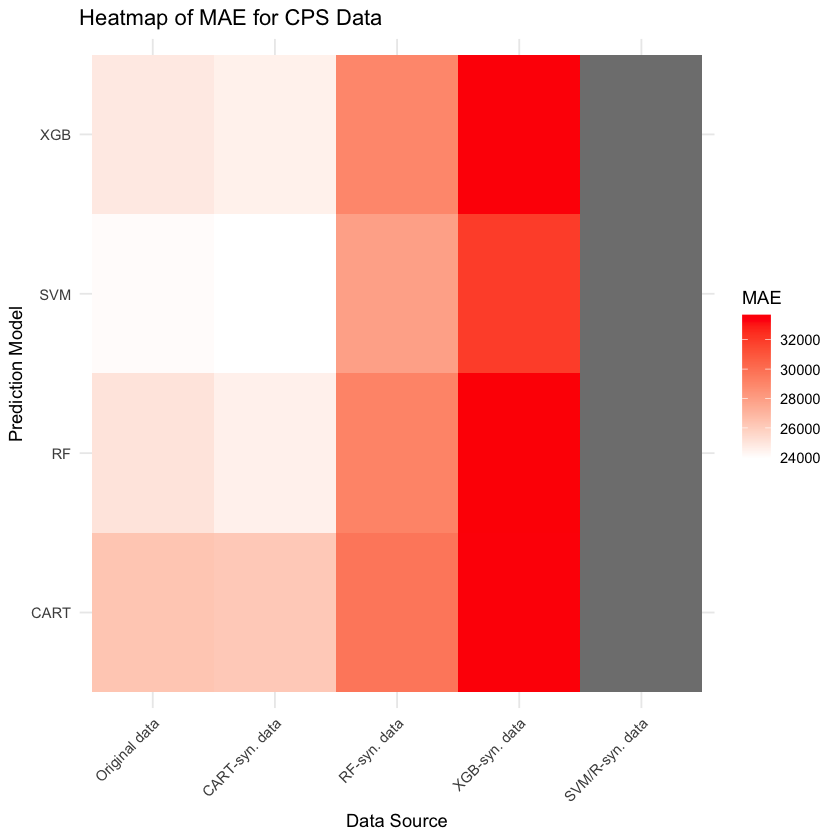

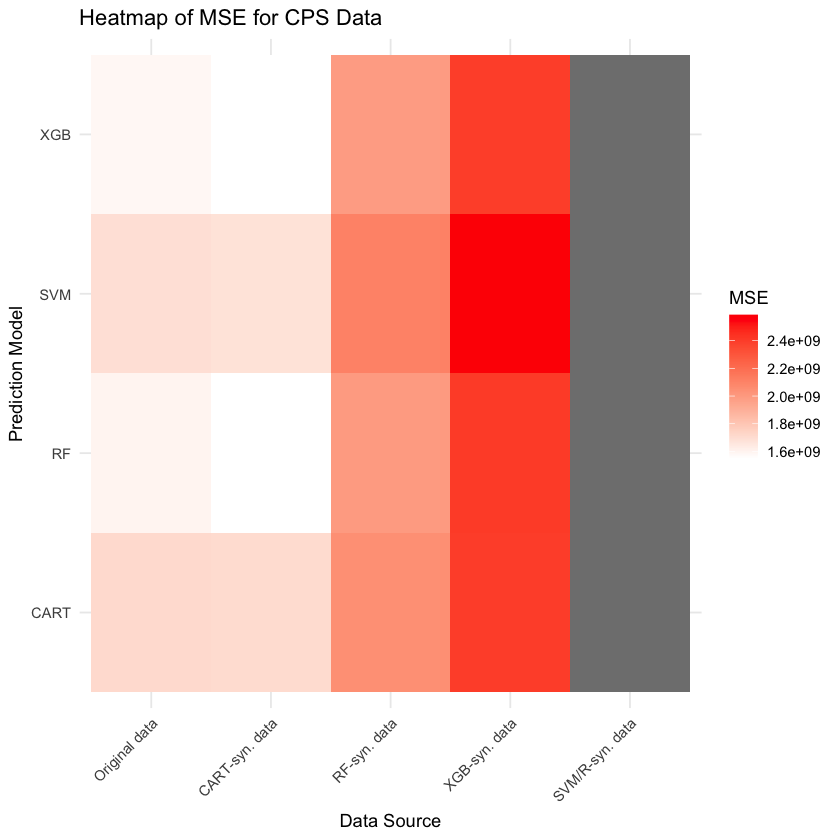

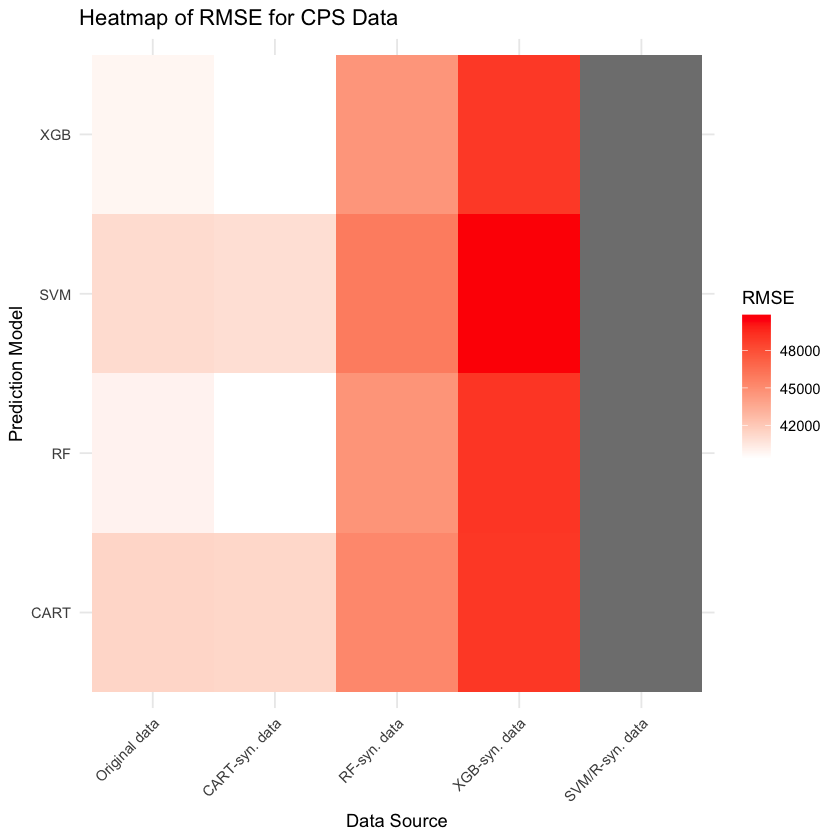

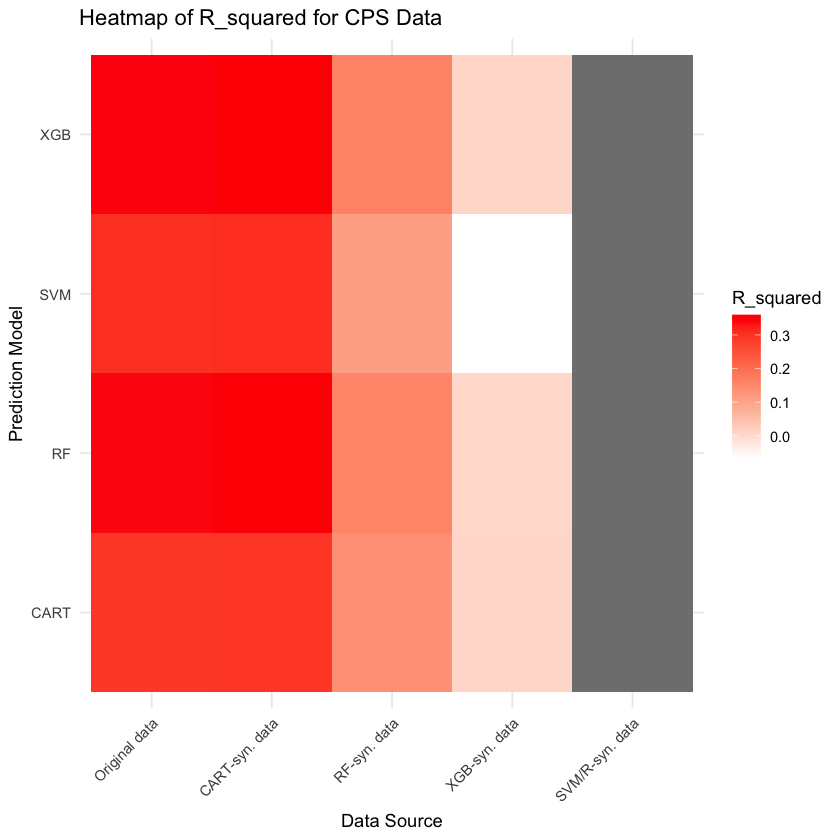

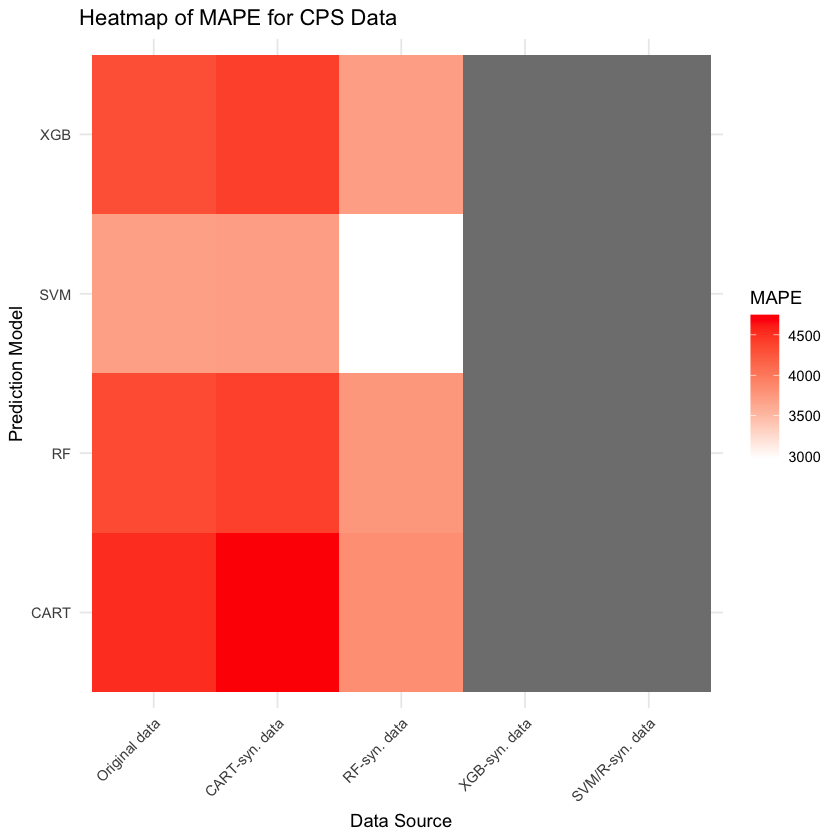

In [142]:
# CPS Data for heatmaps
cps_heatmap_data <- cps_table

# Iterate over each metric in the cps data
for (metric in metrics_regression) {
  # Filter the table for the current metric
  metric_data <- cps_heatmap_data[cps_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "red", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for CPS Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}


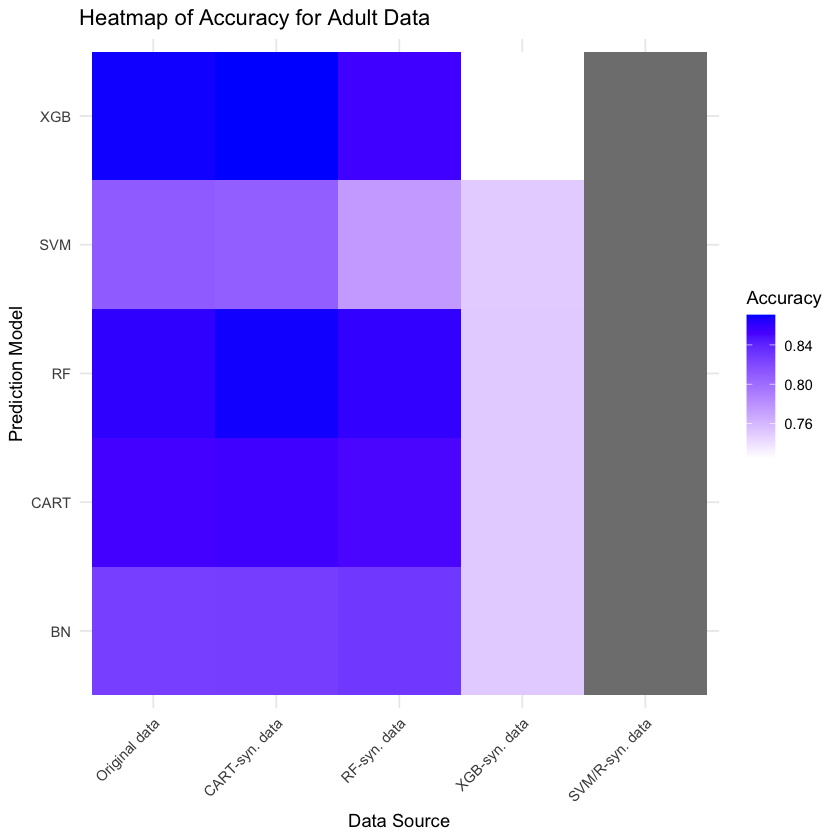

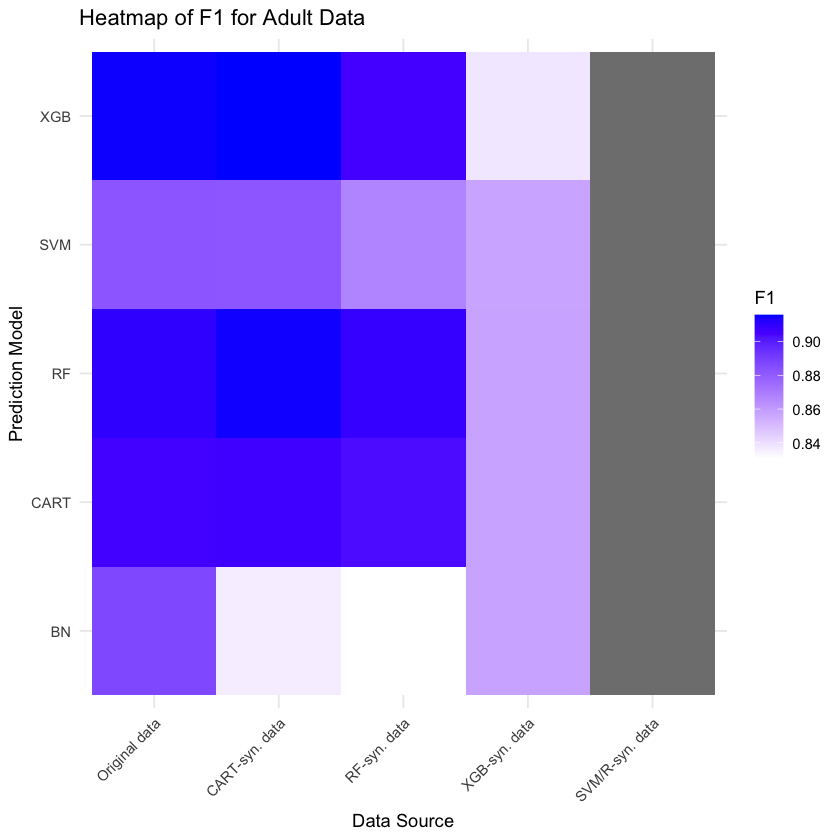

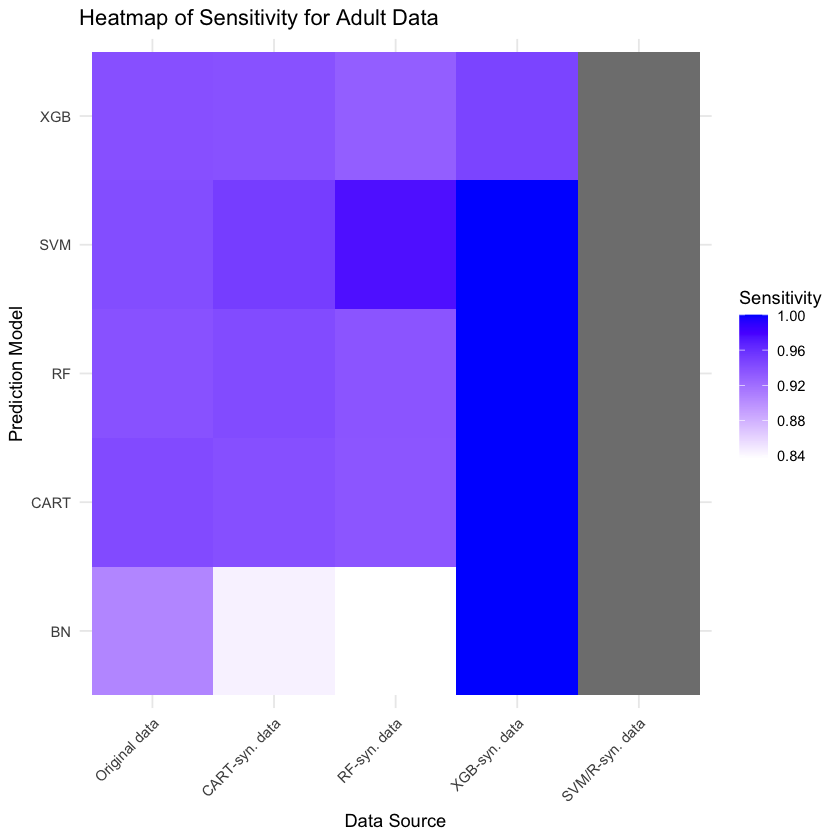

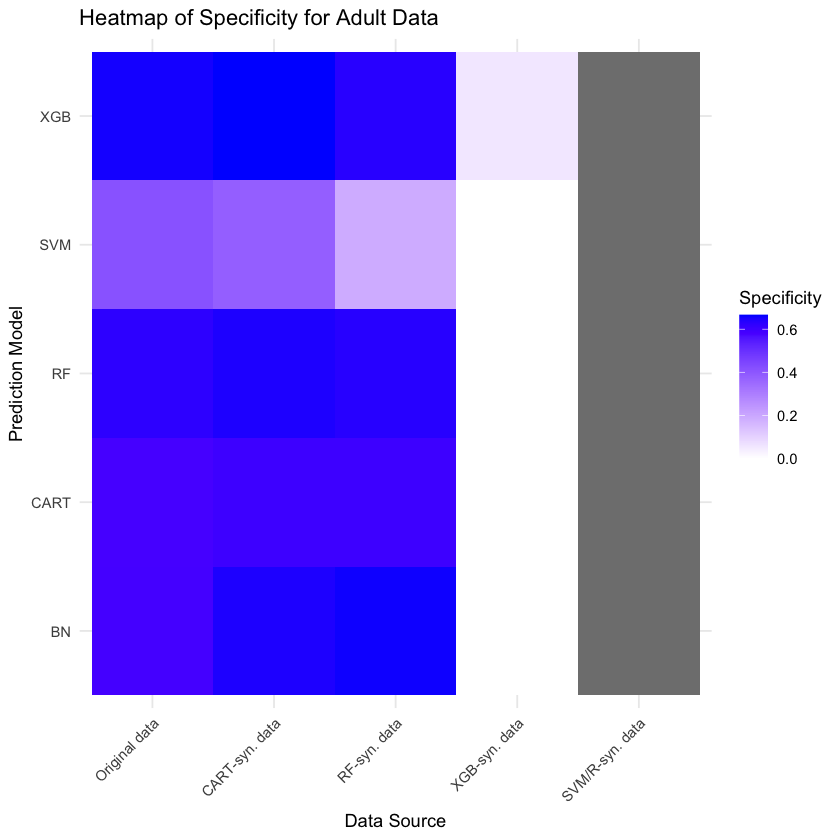

In [143]:
# Adult Data for heatmaps
adult_heatmap_data <- adult_table

# Iterate over each metric in the adult data
for (metric in metrics_classification) {
  # Filter the table for the current metric
  metric_data <- adult_heatmap_data[adult_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "blue", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for Adult Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}


## Prediction on Original data

### CPS orig

In [144]:
(cps_orig_reg <- averaged_data[["cps_og"]])

,MAE,MSE,RMSE,R_squared,MAPE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,26343.33,1714859597,41407.16,0.2916392,4530.668
RF,25034.96,1595924954,39942.33,0.3408800,4340.005
XGB,24831.14,1583878594,39790.27,0.3459001,4314.645
SVM,24080.63,1689493174,41097.85,0.3022338,3702.243


In [145]:
# Load xtable
library(xtable)

# First, convert the relevant columns back to numeric if needed, then round them
cps_orig_reg$MAE <- as.numeric(cps_orig_reg$MAE)
cps_orig_reg$MSE <- as.numeric(cps_orig_reg$MSE)

# Now round the MAE and MSE columns to 2 decimal places
cps_orig_reg$MAE <- round(cps_orig_reg$MAE, 2)
cps_orig_reg$MSE <- round(cps_orig_reg$MSE, 2)

# Format the other numeric columns (except MAE and MSE) to 7 decimal places
cps_orig_reg[] <- lapply(cps_orig_reg, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places for other columns
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframe to xtable
xtable_cps_orig_reg <- xtable(cps_orig_reg, 
                              caption = "CPS Original Data Prediction Metrics", 
                              label = "tab:cps_orig_reg")

# Print the xtable with the desired formatting
print(xtable_cps_orig_reg, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 10:26:00 2024
\begin{table}[ht]
\centering
\begin{tabular}{rlllll}
  \hline
 & MAE & MSE & RMSE & R_squared & MAPE \\ 
  \hline
CART & 26343.3300000 & 1714859596.8599999 & 41407.1577895 & 0.2916392 & 4530.6682699 \\ 
  RF & 25034.9600000 & 1595924953.7000000 & 39942.3272425 & 0.3408800 & 4340.0048706 \\ 
  XGB & 24831.1400000 & 1583878594.2600000 & 39790.2730697 & 0.3459001 & 4314.6447322 \\ 
  SVM & 24080.6300000 & 1689493173.7300000 & 41097.8532208 & 0.3022338 & 3702.2433375 \\ 
   \hline
\end{tabular}
\caption{CPS Original Data Prediction Metrics} 
\label{tab:cps_orig_reg}
\end{table}


In [146]:
(cps_orig_bn <- averaged_data[["cps_og_bn_pred"]])

Accuracy,F1,Sensitivity,Specificity
<dbl>,<dbl>,<dbl>,<dbl>
0.960389,0.9797943,0.22,0.8


In [147]:
# Format all numeric columns to 7 decimal places in cps_orig_class
cps_orig_bn[] <- lapply(cps_orig_bn, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframe to xtable
xtable_cps_orig_class <- xtable(cps_orig_bn, 
                                caption = "CPS Original Data BN Prediction Metrics", 
                                label = "tab:cps_orig_bn")

# Print the xtable without rounding
print(xtable_cps_orig_class, include.rownames = TRUE, sanitize.text.function = identity)

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 10:26:00 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
1 & 0.9603890 & 0.9797943 & 0.2200000 & 0.8000000 \\ 
   \hline
\end{tabular}
\caption{CPS Original Data BN Prediction Metrics} 
\label{tab:cps_orig_bn}
\end{table}


### Adult orig

In [148]:
(adult_orig <- averaged_data[["adult_og"]])

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.8534414,0.9062172,0.9427518,0.5839644
RF,0.8608482,0.9101478,0.9383376,0.6270382
XGB,0.8689708,0.9150572,0.9396884,0.6555945
SVM,0.8107187,0.8825387,0.9416128,0.4157693
BN,0.8264646,0.8868903,0.9060926,0.5864668


In [115]:
# Format all numeric columns to 7 decimal places
adult_orig[] <- lapply(adult_orig, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframe to xtable
xtable_adult_orig <- xtable(adult_orig, 
                            caption = "Adult Original Data Prediction Metrics", 
                            label = "tab:adult_orig")

# Print the xtable without rounding
print(xtable_adult_orig, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Sun Oct 20 16:00:28 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8534414 & 0.9062172 & 0.9427518 & 0.5839644 \\ 
  RF & 0.8608482 & 0.9101478 & 0.9383376 & 0.6270382 \\ 
  XGB & 0.8689708 & 0.9150572 & 0.9396884 & 0.6555945 \\ 
  SVM & 0.8107187 & 0.8825387 & 0.9416128 & 0.4157693 \\ 
  BN & 0.8264646 & 0.8868903 & 0.9060926 & 0.5864668 \\ 
   \hline
\end{tabular}
\caption{Adult Original Data Prediction Metrics} 
\label{tab:adult_orig}
\end{table}


### CPS discretized orig

In [125]:
rownames(averaged_data[["cps_orig_dis_bn_pred"]]) <- "BN"
(cps_orig_dis <- rbind(averaged_data[["cps_orig_dis"]], averaged_data[["cps_orig_dis_bn_pred"]]))

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.9603791,0.9797912,0.2199971,0.8000166
RF,0.9603932,0.9797965,0.2200000,0.8000000
XGB,0.9604114,0.9019285,0.2201137,0.8000919
SVM,0.9603932,0.9797965,0.2200000,0.8000000
BN,0.9603940,0.9797969,0.2200000,0.8000000


In [126]:
# Format all numeric columns to 7 decimal places for cps_orig_dis
cps_orig_dis[] <- lapply(cps_orig_dis, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert the dataframe to an xtable
xtable_cps_orig_dis <- xtable(cps_orig_dis, 
                              caption = "CPS Original Data Prediction Metrics", 
                              label = "tab:cps_orig_dis")

# Print the xtable without rounding
print(xtable_cps_orig_dis, include.rownames = TRUE, sanitize.text.function = identity)

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Sun Oct 20 16:59:07 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.9603791 & 0.9797912 & 0.2199971 & 0.8000166 \\ 
  RF & 0.9603932 & 0.9797965 & 0.2200000 & 0.8000000 \\ 
  XGB & 0.9604114 & 0.9019285 & 0.2201137 & 0.8000919 \\ 
  SVM & 0.9603932 & 0.9797965 & 0.2200000 & 0.8000000 \\ 
  BN & 0.9603940 & 0.9797969 & 0.2200000 & 0.8000000 \\ 
   \hline
\end{tabular}
\caption{CPS Original Data Prediction Metrics} 
\label{tab:cps_orig_dis}
\end{table}


### Adult discretized orig

In [121]:
(adult_orig_dis <- averaged_data[["adult_orig_dis"]])

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.8316757,0.8916508,0.9221991,0.5585375
RF,0.8371926,0.8951397,0.9252052,0.5716326
XGB,0.8431968,0.8981551,0.9205837,0.6096967
SVM,0.8152872,0.8833293,0.9305817,0.4674074
BN,0.8262161,0.8866629,0.9053639,0.5876945


In [127]:
# Extract the 'adult_orig_dis' dataframe
adult_orig_dis <- averaged_data[["adult_orig_dis"]]

# Format all numeric columns to 7 decimal places for adult_orig_dis
adult_orig_dis[] <- lapply(adult_orig_dis, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert the dataframe to an xtable
xtable_adult_orig_dis <- xtable(adult_orig_dis, 
                                caption = "Adult Discretized Data Prediction Metrics", 
                                label = "tab:adult_orig_dis")

# Print the xtable without rounding
print(xtable_adult_orig_dis, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Sun Oct 20 17:00:36 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8316757 & 0.8916508 & 0.9221991 & 0.5585375 \\ 
  RF & 0.8371926 & 0.8951397 & 0.9252052 & 0.5716326 \\ 
  XGB & 0.8431968 & 0.8981551 & 0.9205837 & 0.6096967 \\ 
  SVM & 0.8152872 & 0.8833293 & 0.9305817 & 0.4674074 \\ 
  BN & 0.8262161 & 0.8866629 & 0.9053639 & 0.5876945 \\ 
   \hline
\end{tabular}
\caption{Adult Discretized Data Prediction Metrics} 
\label{tab:adult_orig_dis}
\end{table}


## Prediction on CART data

In [157]:
# Extract the dataframes from averaged_data
cps_cart <- averaged_data[["cps_cart"]]
adult_cart <- averaged_data[["adult_cart"]]

# Filter out BN row and MAPE column
adult_cart <- adult_cart[rownames(adult_cart) != "BN", ]
cps_cart <- cps_cart[, !colnames(cps_cart) %in% "MAPE"]

# Format all numeric columns to 7 decimal places
cps_cart[] <- lapply(cps_cart, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_cart[] <- lapply(adult_cart, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_cart <- xtable(cps_cart, 
                          caption = "CPS CART-Synthesized Data Prediction Metrics", 
                          label = "tab:cps_cart")

xtable_adult_cart <- xtable(adult_cart, 
                            caption = "Adult CART-Synthesized Data Prediction Metrics", 
                            label = "tab:adult_cart")

# Print the xtables without rounding
print(xtable_cps_cart, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_cart, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:23:42 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 26178.4902695 & 1705863260.3988602 & 41289.5052688 & 0.2952757 \\ 
  RF & 24540.4966460 & 1549769835.4098353 & 39356.3951169 & 0.3597545 \\ 
  XGB & 24510.8488644 & 1549601719.9055719 & 39355.7747158 & 0.3597220 \\ 
  SVM & 23928.5528633 & 1676849659.6953473 & 40938.4980827 & 0.3072423 \\ 
   \hline
\end{tabular}
\caption{CPS CART-Synthesized Data Prediction Metrics} 
\label{tab:cps_cart}
\end{table}


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:23:42 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8546714 & 0.9065522 & 0.9398256 & 0.5989968 \\ 
  RF & 0.8685068 & 0.9148870 & 0.9421881 & 0.6473191 \\ 
  XGB & 0.8706121 & 0.9158385 & 0.9386075 & 0.6665026 \\ 
  SVM & 0.8080343 & 0.8823105 & 0.9510607 & 0.3794122 \\ 
   \hline
\end{tabular}
\caption{Adult CART-Synthesized Data Prediction Metrics} 
\label{tab:adult_cart}
\end{table}


## Prediction on RF data

In [158]:
# Extract the dataframes from averaged_data
cps_rf <- averaged_data[["cps_rf"]]
adult_rf <- averaged_data[["adult_rf"]]

# Filter out BN row and MAPE column
adult_rf <- adult_rf[rownames(adult_rf) != "BN", ]
cps_rf <- cps_rf[, !colnames(cps_rf) %in% "MAPE"]

# Format all numeric columns to 7 decimal places
cps_rf[] <- lapply(cps_rf, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_rf[] <- lapply(adult_rf, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_rf <- xtable(cps_rf, 
                        caption = "CPS RF-Synthesized Data Prediction Metrics", 
                        label = "tab:cps_rf")

xtable_adult_rf <- xtable(adult_rf, 
                          caption = "Adult RF-Synthesized Data Prediction Metrics", 
                          label = "tab:adult_rf")

# Print the xtables without rounding
print(xtable_cps_rf, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_rf, include.rownames = TRUE, sanitize.text.function = identity)

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:26:44 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 29679.6329495 & 2049007653.3870442 & 45256.9219814 & 0.1364925 \\ 
  RF & 29138.6183892 & 1996587550.4181232 & 44670.6986245 & 0.1586550 \\ 
  XGB & 28986.3671764 & 1988414595.8645205 & 44579.5579503 & 0.1620785 \\ 
  SVM & 27906.2933645 & 2106843603.4392738 & 45892.2096438 & 0.1121906 \\ 
   \hline
\end{tabular}
\caption{CPS RF-Synthesized Data Prediction Metrics} 
\label{tab:cps_rf}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:26:44 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8507320 & 0.9034699 & 0.9357817 & 0.6000756 \\ 
  RF & 0.8600705 & 0.9090237 & 0.9365271 & 0.6348330 \\ 
  XGB & 0.8549977 & 0.9054514 & 0.9301502 & 0.6335968 \\ 
  SVM & 0.7751624 & 0.86

## Prediction on XGB data

In [159]:
# Extract the dataframes from averaged_data
cps_xgb <- averaged_data[["cps_xgb"]]
adult_xgb <- averaged_data[["adult_xgb"]]

# Filter out BN row and MAPE column
adult_xgb <- adult_xgb[rownames(adult_xgb) != "BN", ]
cps_xgb <- cps_xgb[, !colnames(cps_xgb) %in% "MAPE"]

# Format all numeric columns to 7 decimal places
cps_xgb[] <- lapply(cps_xgb, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_xgb[] <- lapply(adult_xgb, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_xgb <- xtable(cps_xgb, 
                         caption = "CPS XGB-Synthesized Data Prediction Metrics", 
                         label = "tab:cps_xgb")

xtable_adult_xgb <- xtable(adult_xgb, 
                           caption = "Adult XGB-Synthesized Data Prediction Metrics", 
                           label = "tab:adult_xgb")

# Print the xtables without rounding
print(xtable_cps_xgb, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_xgb, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:29:32 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 33607.1805764 & 2404325889.0473032 & 49024.0530333 &  0.007876763 \\ 
  RF & 33686.0111884 & 2410918011.7946634 & 49093.2028765 &  0.005158165 \\ 
  XGB & 33615.5693367 & 2400645691.9972792 & 48988.3500239 &  0.009347251 \\ 
  SVM & 31962.0718938 & 2586428611.7813888 & 50850.0201227 & -0.067223898 \\ 
   \hline
\end{tabular}
\caption{CPS XGB-Synthesized Data Prediction Metrics} 
\label{tab:cps_xgb}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:29:32 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.7502520 & 0.8572989 & 0.9999512 & 0.0001190524 \\ 
  RF & 0.7502818 & 0.8573022 & 0.9998585 & 0.0005176379 \\ 
  XGB & 0.7244049 & 0.8376064 & 0.9473852 & 0.0545109240 \\ 
 

## Prediction on SVM data

## Prediction on BN data

In [165]:
# Extract the dataframes from averaged_data
cps_bn <- rbind(averaged_data[["cps_bn"]], averaged_data[["cps_bn_bn_pred"]])
rownames(cps_bn)[nrow(cps_bn)] <- "BN"
adult_bn <- averaged_data[["adult_bn"]]

# Format all numeric columns to 7 decimal places
cps_bn[] <- lapply(cps_bn, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_bn[] <- lapply(adult_bn, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_bn <- xtable(cps_bn, 
                        caption = "CPS BN-Synthesized Data Prediction Metrics", 
                        label = "tab:cps_bn")

xtable_adult_bn <- xtable(adult_bn, 
                          caption = "Adult BN-Synthesized Data Prediction Metrics", 
                          label = "tab:adult_bn")

# Print the xtables without rounding
print(xtable_cps_bn, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_bn, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:32:07 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.9601050 & 0.9796463 & 0.2137489 & 0.7999990 \\ 
  RF & 0.9600848 & 0.9674681 & 0.2137583 & 0.8000067 \\ 
  XGB & 0.9601050 & 0.9796476 & 0.2137489 & 0.8000113 \\ 
  SVM & 0.9601100 & 0.9796490 & 0.2137500 & 0.8000000 \\ 
  BN & 0.9601013 & 0.9796444 & 0.2137500 & 0.8000000 \\ 
   \hline
\end{tabular}
\caption{CPS BN-Synthesized Data Prediction Metrics} 
\label{tab:cps_bn}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Mon Oct 21 11:32:07 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8344655 & 0.8944789 & 0.9293075 & 0.5421744 \\ 
  RF & 0.8365826 & 0.8959101 & 0.9315319 & 0.5439881 \\ 
  XGB & 0.8422613 & 0.8988330 & 0.9281727 & 0.5774868 \\ 
  SVM & 0.8144355 & 0.